# Combine, clean, and export the data
### By Minh Phan

Now that we have all the data we need, it's time to synthesize the variables together

## Loading data
Begin by loading all the data into disk

In [47]:
import xarray as xr
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

In [5]:
era5 = xr.combine_by_coords([xr.open_mfdataset('demonstrated data/era5/eastward_wind_at_10_metres/*.nc'),
                             xr.open_mfdataset('demonstrated data/era5/northward_wind_at_10_metres/*.nc'),
                            xr.open_mfdataset('demonstrated data/era5/sea_surface_temperature/*.nc'),
                            xr.open_mfdataset('demonstrated data/era5/air_temperature_at_2_metres/*.nc')])
motu = xr.combine_by_coords([xr.open_mfdataset('demonstrated data/motu/*/*.nc')])

In [25]:
currents = xr.open_mfdataset('demonstrated data/earth_data/OSCAR_L4_OC_FINAL_V2.0/*.nc')

**ISSUE WITH EARTHDATA DATASET**: As mentioned in the first notebook, we found out that the xarray Dataset object created from the currents dataset is not indexed properly, and wehad two approaches to deal with this issue when combining this object to the rest of the datasets [screenshot error when attempt slicing?]:

1. Add all variables of this dataset to the final combined dataset and make sure that the order and shape remain consistent
2. Replace coordinate systems from other already cleaned datasets

## Process ERA5 data and calculate speed/direction

In [6]:
# adding calculated variables (direction and speed)
era5 = era5.assign(speed = np.sqrt(era5.eastward_wind_at_10_metres**2 + era5.northward_wind_at_10_metres**2))
era5 = era5.assign(direction = np.rad2deg(np.arctan2(era5.northward_wind_at_10_metres, era5.eastward_wind_at_10_metres)))

# coarsen
era5 = era5.coarsen(time0=24).mean(keep_attrs=True).compute()

In [7]:
era5 = era5.rename({'time0': 'time', 
                    'eastward_wind_at_10_metres': 'u_wind', 
                    'northward_wind_at_10_metres': 'v_wind',
                   'air_temperature_at_2_metres': 'air_temp',
                   'sea_surface_temperature': 'sst'})

In [48]:
# fix time coordinate by resetting to 12AM
era5 = era5.assign_coords(time=np.arange('2000-01-01', '2002-01-01', timedelta(days=1), dtype='datetime64[ns]'))

In [49]:
era5

<xarray.Dataset>
Dimensions:    (time: 731, lat: 81, lon: 81)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2001-12-31
  * lon        (lon) float32 60.0 60.25 60.5 60.75 ... 79.25 79.5 79.75 80.0
  * lat        (lat) float32 25.0 24.75 24.5 24.25 24.0 ... 5.75 5.5 5.25 5.0
Data variables:
    air_temp   (time, lat, lon) float32 295.9 295.9 295.8 ... 299.7 299.7 299.7
    u_wind     (time, lat, lon) float32 -4.113 -4.231 -4.331 ... nan nan nan
    v_wind     (time, lat, lon) float32 0.95 0.8631 0.7149 ... nan nan nan
    sst        (time, lat, lon) float32 297.7 297.8 297.8 297.6 ... nan nan nan
    speed      (time, lat, lon) float32 4.488 4.625 4.767 4.724 ... nan nan nan
    direction  (time, lat, lon) float32 33.59 19.3 5.515 8.595 ... nan nan nan
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    tilte:        ERA5 forecasts

## Process EARTH DATA Currents

In [26]:
# interpolate
### Convert time from CF time to datetime
currents['time'] = currents.indexes['time'].to_datetimeindex()

/tmp/ipykernel_364/1754246052.py:3: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  currents['time'] = currents.indexes['time'].to_datetimeindex()


In [27]:
currents

<xarray.Dataset>
Dimensions:  (latitude: 177, longitude: 241, time: 732)
Coordinates:
    lat      (latitude) float64 dask.array<chunksize=(177,), meta=np.ndarray>
    lon      (longitude) float64 dask.array<chunksize=(241,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2002-01-01
Dimensions without coordinates: latitude, longitude
Data variables:
    u        (time, longitude, latitude) float64 dask.array<chunksize=(366, 241, 177), meta=np.ndarray>
    v        (time, longitude, latitude) float64 dask.array<chunksize=(366, 241, 177), meta=np.ndarray>
    ug       (time, longitude, latitude) float64 dask.array<chunksize=(366, 241, 177), meta=np.ndarray>
    vg       (time, longitude, latitude) float64 dask.array<chunksize=(366, 241, 177), meta=np.ndarray>
Attributes: (12/36)
    title:                      Ocean Surface Current Analyses Real-time (OSC...
    summary:                    Global, daily, 0.25 degree geostrophic and to...
    keywords:                   ocean currents,ocean circulation,surface curr...
    Conventions:                CF-1.8 Standard Names v77, ACDD-1.3, netcdf 4...
    id:                         OSCAR_L4_OC_FINAL_V2.0
    history:                    OSCAR 0.25 degree daily version 2.0 replaces ...
    ...                         ...
    geospatial_lon_max:         359.75
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.25 degree
    time_coverage_start:        2000-01-01T00:00:00
    time_coverage_end:          2000-01-01T23:59:59
    date_created:               2022-01-07

### Rebuild dataset
As we mentioned, the latitude and longitude dimensions on this dataset are not properly indexed, hence Xarray interpolation using `interp()` or `interp_like()` will not work. We are going to build another dataset from the ground up to fix this issue.

In [32]:
# attempt to properly index
lats = currents.lat.values
lons = currents.lon.values
time = currents.time.values

idx = pd.MultiIndex.from_product([time, lons, lats], names=['time', 'lon', 'lat'])
d = { 'u': currents.u.values.flatten(), 
     'v': currents.v.values.flatten(),
     'ug': currents.ug.values.flatten(),
     'vg': currents.vg.values.flatten()}
df = pd.DataFrame(d, index=idx)

In [33]:
ds = xr.Dataset.from_dataframe(df)

In [41]:
currents_sliced = ds.sel(lat=slice(5, 25), lon=slice(60, 80)).transpose('time', 'lat', 'lon')

In [50]:
currents_interp = currents_sliced.interp_like(era5)

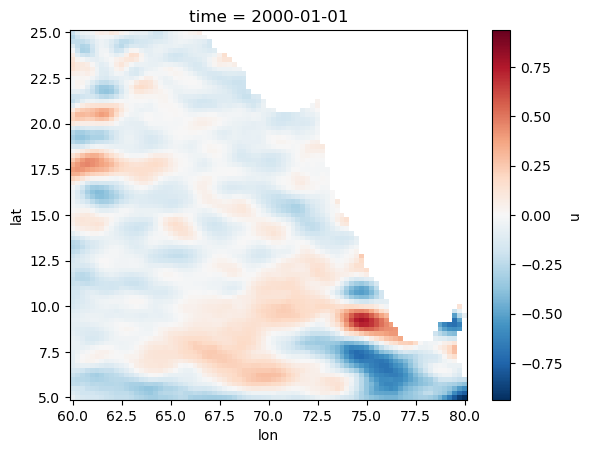

In [51]:
currents_interp.isel(time=0).u.plot.imshow()

In [54]:
currents_interp

<xarray.Dataset>
Dimensions:  (time: 731, lat: 81, lon: 81)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2001-12-31
  * lon      (lon) float32 60.0 60.25 60.5 60.75 61.0 ... 79.25 79.5 79.75 80.0
  * lat      (lat) float32 25.0 24.75 24.5 24.25 24.0 ... 6.0 5.75 5.5 5.25 5.0
Data variables:
    u        (time, lat, lon) float64 -0.2163 -0.1152 ... -0.6347 -0.7386
    v        (time, lat, lon) float64 0.1758 0.1223 0.0406 ... 0.1429 0.1075
    ug       (time, lat, lon) float64 -0.2121 -0.1098 ... -0.4791 -0.5703
    vg       (time, lat, lon) float64 0.1709 0.1173 ... 0.02541 -0.003819

## Process MOTU-Copernicus datasets

In [55]:
# inspecting motu, seeing that CHL & sla variables have different grids
# solution: interpolate and add to our dataset
motu

<xarray.Dataset>
Dimensions:          (time: 731, lat: 481, lon: 481, latitude: 81, longitude: 81)
Coordinates:
  * time             (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2001-12-31
  * lat              (lat) float32 25.02 24.98 24.94 24.9 ... 5.104 5.062 5.021
  * lon              (lon) float32 59.98 60.02 60.06 60.1 ... 79.9 79.94 79.98
  * latitude         (latitude) float32 4.875 5.125 5.375 ... 24.38 24.62 24.88
  * longitude        (longitude) float32 59.88 60.12 60.38 ... 79.38 79.62 79.88
Data variables:
    CHL_uncertainty  (time, lat, lon) float32 dask.array<chunksize=(31, 481, 481), meta=np.ndarray>
    CHL              (time, lat, lon) float32 dask.array<chunksize=(31, 481, 481), meta=np.ndarray>
    adt              (time, latitude, longitude) float64 dask.array<chunksize=(31, 81, 81), meta=np.ndarray>
    crs              (time) int32 -2147483647 -2147483647 ... -2147483647
    sla              (time, latitude, longitude) float64 dask.array<chunksize=(31, 81, 81), meta=np.ndarray>
Attributes: (12/92)
    lon_step:                        0.041666668
    keywords:                        EARTH SCIENCE > OCEANS > OCEAN CHEMISTRY...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L4_MY_009_104
    lat_step:                        0.041666668
    grid_mapping:                    Equirectangular
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l4-gapf...
    ...                              ...
    westernmost_longitude:           -180.0
    geospatial_vertical_positive:    up
    date_created:                    2023-07-09T01:28:25Z
    nb_valid_bins:                   18891348
    pct_valid_bins:                  50.61339377572016
    History:                         Translated to CF-1.0 Conventions by Netc...

In [56]:
CHL_interp = motu[['CHL', 'CHL_uncertainty']].interp_like(era5)

In [69]:
# rename before interpolation
SLA_interp = motu[['sla', 'adt']].rename({'latitude': 'lat', 'longitude': 'lon'})

In [70]:
SLA_interp = SLA_interp.interp_like(era5)
SLA_interp

<xarray.Dataset>
Dimensions:  (time: 731, lat: 81, lon: 81)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2001-12-31
  * lon      (lon) float32 60.0 60.25 60.5 60.75 61.0 ... 79.25 79.5 79.75 80.0
  * lat      (lat) float32 25.0 24.75 24.5 24.25 24.0 ... 6.0 5.75 5.5 5.25 5.0
Data variables:
    sla      (time, lat, lon) float64 dask.array<chunksize=(731, 81, 81), meta=np.ndarray>
    adt      (time, lat, lon) float64 dask.array<chunksize=(731, 81, 81), meta=np.ndarray>
Attributes: (12/92)
    lon_step:                        0.041666668
    keywords:                        EARTH SCIENCE > OCEANS > OCEAN CHEMISTRY...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L4_MY_009_104
    lat_step:                        0.041666668
    grid_mapping:                    Equirectangular
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l4-gapf...
    ...                              ...
    westernmost_longitude:           -180.0
    geospatial_vertical_positive:    up
    date_created:                    2023-07-09T01:28:25Z
    nb_valid_bins:                   18891348
    pct_valid_bins:                  50.61339377572016
    History:                         Translated to CF-1.0 Conventions by Netc...

In [53]:
CHL_interp

<xarray.Dataset>
Dimensions:          (time: 731, lat: 81, lon: 81)
Coordinates:
  * time             (time) datetime64[ns] 2000-01-01T11:30:00 ... 2001-12-31...
  * lon              (lon) float32 60.0 60.25 60.5 60.75 ... 79.5 79.75 80.0
  * lat              (lat) float32 25.0 24.75 24.5 24.25 ... 5.75 5.5 5.25 5.0
Data variables:
    CHL              (time, lat, lon) float32 dask.array<chunksize=(731, 81, 81), meta=np.ndarray>
    CHL_uncertainty  (time, lat, lon) float32 dask.array<chunksize=(731, 81, 81), meta=np.ndarray>
Attributes: (12/92)
    lon_step:                        0.041666668
    keywords:                        EARTH SCIENCE > OCEANS > OCEAN CHEMISTRY...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L4_MY_009_104
    lat_step:                        0.041666668
    grid_mapping:                    Equirectangular
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l4-gapf...
    ...                              ...
    westernmost_longitude:           -180.0
    geospatial_vertical_positive:    up
    date_created:                    2023-07-09T01:28:25Z
    nb_valid_bins:                   18891348
    pct_valid_bins:                  50.61339377572016
    History:                         Translated to CF-1.0 Conventions by Netc...

## Combine files together

Due to different attributes in each dataset coordinates, we cannot combine all datasets together by coords by simply using the combine_by_coords() function in xarray. Issue is replicated below:

In [58]:
final_ds = xr.combine_by_coords([CHL_interp, SLA_interp, currents_interp, era5])

MergeError: combine_attrs='no_conflicts', but some values are not the same. Merging {'lon_step': 0.041666668, 'keywords': 'EARTH SCIENCE > OCEANS > OCEAN CHEMISTRY > CHLOROPHYLL', 'cmems_product_id': 'OCEANCOLOUR_GLO_BGC_L4_MY_009_104', 'lat_step': 0.041666668, 'grid_mapping': 'Equirectangular', 'title': 'cmems_obs-oc_glo_bgc-plankton_my_l4-gapfree-multi-4km_P1D', 'period_end_day': '20230701', 'duration_time': 'PT149454S', 'standard_name_vocabulary': 'NetCDF Climate and Forecast (CF) Metadata Convention', 'nb_equ_bins': 8640, 'geospatial_bounds': 'POLYGON ((90.000000 -180.000000, 90.000000 180.000000, -90.000000 180.000000, -90.000000 -180.000000, 90.000000 -180.000000))', 'overall_quality': 'mode=myint', 'DPM_reference': 'GC-UD-ACRI-PUG', 'stop_date': '2023-07-02 UTC', 'time_coverage_start': '2023-06-30T15:15:06Z', 'grid_resolution': 4.6383123, 'sensor_name': 'MODISA,VIIRSN,OLCIa,VIIRSJ1,OLCIb', 'summary': 'CMEMS product: cmems_obs-oc_glo_bgc-plankton_my_l4-gapfree-multi-4km_P1D,  generated by ACRI-ST', 'westernmost_valid_longitude': -180.0, 'source': 'surface observation', 'pct_bins': 100.0, 'distribution_statement': 'See CMEMS Data License', 'geospatial_bounds_crs': 'EPSG:4326', 'parameter_code': 'CHL', 'creation_time': '01:28:25 UTC', 'software_name': 'globcolour_l3_reproject', 'creation_date': '2023-07-09 UTC', 'Conventions': 'CF-1.8, ACDD-1.3', 'sensor': 'Moderate Resolution Imaging Spectroradiometer,Visible Infrared Imaging Radiometer Suite,Ocean and Land Colour Instrument', 'time_coverage_duration': 'PT149454S', 'keywords_vocabulary': 'NASA Global Change Master Directory (GCMD) Science Keywords', 'southernmost_valid_latitude': -53.04167, 'license': 'See CMEMS Data License', 'comment': 'average', 'time_coverage_resolution': 'P1D', 'geospatial_vertical_max': 0, 'references': 'http://www.globcolour.info GlobColour has been originally funded by ESA with data from ESA, NASA, NOAA and GeoEye. This version has received funding from the European Community s Seventh Framework Programme ([FP7/2007-2013]) under grant agreement n. 282723 [OSS2015 project].', 'registration': 5, 'nb_grid_bins': 37324800, 'geospatial_lat_max': 25.020832061767578, 'publication': 'Gohin, F., Druon, J. N., Lampert, L. (2002). A five channel chlorophyll concentration algorithm applied to SeaWiFS data processed by SeaDAS in coastal waters. International journal of remote sensing, 23(8), 1639-1661 + Hu, C., Lee, Z., Franz, B. (2012). Chlorophyll a algorithms for oligotrophic oceans: A novel approach based on three-band reflectance difference. Journal of Geophysical Research, 117(C1). doi: 10.1029/2011jc007395', 'platform': 'Aqua,Suomi-NPP,Sentinel-3a,JPSS-1 (NOAA-20),Sentinel-3b', 'northernmost_valid_latitude': 88.75, 'northernmost_latitude': 90.0, 'IODD_reference': 'GC-UD-ACRI-PUG', 'start_date': '2023-06-30 UTC', 'processing_level': 'L4', 'product_level': 4, 'citation': 'The Licensees will ensure that original CMEMS products - or value added products or derivative works developed from CMEMS Products including publications and pictures - shall credit CMEMS by explicitly making mention of the originator (CMEMS) in the  following manner:  <Generated using CMEMS Products, production centre ACRI-ST>', 'software_version': '2022.2', 'creator_email': 'servicedesk.cmems@acri-st.fr', 'nb_bins': 37324800, 'easternmost_valid_longitude': 180.00002, 'geospatial_lat_min': 5.0208306312561035, 'institution': 'ACRI', 'geospatial_lon_max': 79.97917175292969, 'geospatial_lon_min': 59.97917556762695, 'acknowledgement': 'The Licensees will ensure that original CMEMS products - or value added products or derivative works developed from CMEMS Products including publications and pictures - shall credit CMEMS by explicitly making mention of the originator (CMEMS) in the  following manner:  <Generated using CMEMS Products, production centre ACRI-ST>', 'project': 'CMEMS', 'file_quality_index': 0, 'southernmost_latitude': -90.0, 'period_duration_day': 'P1D', 'history': 'Created using software developed at ACRI-ST', 'site_name': 'GLO', 'geospatial_bounds_vertical_crs': 'EPSG:5829', 'easternmost_longitude': 180.0, 'publisher_name': 'CMEMS', 'id': '20230701_cmems_obs-oc_glo_bgc-plankton_myint_l4-gapfree-multi-4km_P1D', 'naming_authority': 'CMEMS', 'earth_radius': 6378.137, 'netcdf_version_id': '4.3.3.1 of Jul  8 2016 18:15:50 $', 'stop_time': '08:45:59 UTC', 'publisher_url': 'http://marine.copernicus.eu', 'parameter': 'Chlorophyll-a concentration', 'start_time': '15:15:06 UTC', 'cmems_production_unit': 'OC-ACRI-NICE-FR', 'period_start_day': '20230701', 'publisher_email': 'servicedesk.cmems@mercator-ocean.eu', 'geospatial_vertical_min': 0, 'creator_url': 'http://marine.copernicus.eu', 'sensor_name_list': 'MOD,VIR,OLA,VJ1,OLB', 'product_type': 'day', 'creator_name': 'ACRI', 'time_coverage_end': '2023-07-02T08:45:59Z', 'product_name': '20230701_cmems_obs-oc_glo_bgc-plankton_myint_l4-gapfree-multi-4km_P1D', 'contact': 'servicedesk.cmems@acri-st.fr', 'westernmost_longitude': -180.0, 'geospatial_vertical_positive': 'up', 'date_created': '2023-07-09T01:28:25Z', 'nb_valid_bins': 18891348, 'pct_valid_bins': 50.61339377572016, 'History': 'Translated to CF-1.0 Conventions by Netcdf-Java CDM (CFGridWriter2)\nOriginal Dataset = cmems_obs-oc_glo_bgc-plankton_my_l4-gapfree-multi-4km_P1D; Translation Date = 2023-07-10T07:32:34.880Z'} with {'source': 'Reanalysis', 'institution': 'ECMWF', 'tilte': 'ERA5 forecasts'}

Therefore, we propose a solution for this issue. Now that we are sure that the dimension/coordinate sizes and names are identical on all variables, we am going to use only one dataset's set of coordinates as the anchor for the final dataset, and add variables to this dataset as we go.

In [71]:
# only applied for data that has same dimensions but different attributes
def combine_transposed(target_arr, list_of_objs):
    target_dim_order = list(target_arr.dims.keys())
    print(target_dim_order)
    for obj in list_of_objs:
        vars_ = [i for i in obj.data_vars]
        obj_transposed = obj[target_dim_order+ vars_]
        # print(obj_transposed)
        for var in vars_:
            print(f'Adding {var} to target dataset...')
            target_arr[var] = (['time', 'lat', 'lon'], obj_transposed[var].values)
    return target_arr

In [72]:
final_ds = combine_transposed(era5, [CHL_interp, SLA_interp, currents_interp])

['time', 'lat', 'lon']
Adding CHL to target dataset...
Adding CHL_uncertainty to target dataset...
Adding sla to target dataset...
Adding adt to target dataset...
Adding u to target dataset...
Adding v to target dataset...
Adding ug to target dataset...
Adding vg to target dataset...


## Adding metadata and rename variables

Metadata is one aspect we also need to address. Correct metadata is vital especially when we want to share our final dataset for others to use, or when we want to graph and feed data for other tools to work on. As we combine and process variables into the final dataset, some of the metadata may be lost, so we need to make sure that their metadata is reserved and resolve any conflict for the export process to proceed smoothly.

In [74]:
final_ds = final_ds.rename({'u': 'u_curr', 'v': 'v_curr', 'ug': 'ug_curr', 'vg': 'vg_curr'})

In [94]:
final_ds['speed'].attrs = {
    'units': 'm s**-1',
    'long_name': '10 metre absolute speed'
}

final_ds['direction'].attrs = {
    'units': '°C',
    'long_name': '10 metre wind direction'
}

final_ds['CHL_uncertainty'].attrs = CHL_interp['CHL_uncertainty'].attrs
final_ds['CHL'].attrs = CHL_interp['CHL'].attrs

final_ds.u_curr.attrs = currents.u.attrs
final_ds.v_curr.attrs = currents.v.attrs
final_ds.ug_curr.attrs = currents.ug.attrs
final_ds.vg_curr.attrs = currents.vg.attrs

final_ds.sla.attrs = SLA_interp.sla.attrs
final_ds.adt.attrs = SLA_interp.adt.attrs
final_ds.time.attrs = SLA_interp.time.attrs

In [92]:
final_ds.attrs = {
    'title': 'Sample of Climate Data for Coastal Upwelling Machine Learning Project in Indian Ocean',
    'summary': "Daily mean of 0.25 x 0.25 degrees gridded data from multiple climate variables that may influence the patterns of coastal upwelling in the focused area",
    'creator_name': 'Minh Phan',
    'creator_email': 'minhphan@uw.edu',
    'creator_type': 'person',
    'source': 'OSCAR, ERA5 Reanalysis, Copernicus Climate Change Service (C3S), Copernicus Marine Environment Monitoring Service (CMEMS)',
    'geospatial_lat_min': float(final_ds.lat.min().values),
    'geospatial_lat_max': float(final_ds.lat.max().values),
    'geospatial_lat_units': 'degrees_north',
    'geospatial_lat_resolution': 0.25,
    'geospatial_lon_min': float(final_ds.lon.min().values),
    'geospatial_lon_max': float(final_ds.lon.max().values),
    'geospatial_lon_units': 'degrees_east',
    'geospatial_lon_resolution': 0.25,
    'time_coverage_start': '2000-01-01T00:00:00',
    'time_coverage_end': '2002-12-31T23:59:59',
    'date_created': datetime.today().strftime('%Y-%d-%d')
}

In [95]:
final_ds

<xarray.Dataset>
Dimensions:          (time: 731, lat: 81, lon: 81)
Coordinates:
  * time             (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2001-12-31
  * lon              (lon) float32 60.0 60.25 60.5 60.75 ... 79.5 79.75 80.0
  * lat              (lat) float32 25.0 24.75 24.5 24.25 ... 5.75 5.5 5.25 5.0
Data variables: (12/14)
    air_temp         (time, lat, lon) float32 295.9 295.9 295.8 ... 299.7 299.7
    u_wind           (time, lat, lon) float32 -4.113 -4.231 -4.331 ... nan nan
    v_wind           (time, lat, lon) float32 0.95 0.8631 0.7149 ... nan nan nan
    sst              (time, lat, lon) float32 297.7 297.8 297.8 ... nan nan nan
    speed            (time, lat, lon) float32 4.488 4.625 4.767 ... nan nan nan
    direction        (time, lat, lon) float32 33.59 19.3 5.515 ... nan nan nan
    ...               ...
    sla              (time, lat, lon) float64 nan nan nan ... 0.1047 0.1042 nan
    adt              (time, lat, lon) float64 nan nan nan ... 0.9005 0.9016 nan
    u_curr           (time, lat, lon) float64 -0.2163 -0.1152 ... -0.7386
    v_curr           (time, lat, lon) float64 0.1758 0.1223 ... 0.1429 0.1075
    ug_curr          (time, lat, lon) float64 -0.2121 -0.1098 ... -0.5703
    vg_curr          (time, lat, lon) float64 0.1709 0.1173 ... -0.003819
Attributes: (12/17)
    title:                      Sample of Climate Data for Coastal Upwelling ...
    summary:                    Daily mean of 0.25 x 0.25 degrees gridded dat...
    creator_name:               Minh Phan
    creator_email:              minhphan@uw.edu
    creator_type:               person
    source:                     OSCAR, ERA5 Reanalysis, Copernicus Climate Ch...
    ...                         ...
    geospatial_lon_max:         80.0
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.25
    time_coverage_start:        2000-01-01T00:00:00
    time_coverage_end:          2002-12-31T23:59:59
    date_created:               2023-11-11

## Adding consistency across variables: convert data types, rechunking

Note that some variables has float64 dtype, while others have float32. We want to add consistency by converting all of them to float32 to save some disk space. The precision from float64 is most likely not going to be lost after the conversion, as our figures do not have enough precision to exceed the limit.

In [98]:
for var in final_ds.data_vars:
    if str(final_ds[var].dtype) == 'float64':
        final_ds[var].values = final_ds[var].astype('float32')

We also need to rechunk the dataset before we can export the data. Some of the variables have original chunk sizes, which is specified in their encodings, and we need to reset these values so that zarr would not reconvert the encoding when export is happening. This is a [known issue](https://stackoverflow.com/questions/67476513/zarr-not-respecting-chunk-size-from-xarray-and-reverting-to-original-chunk-size).


In [101]:
for var in final_ds.data_vars:
    if 'chunks' in list(final_ds[var].encoding.keys()):
        del final_ds[var].encoding['chunks']

In [103]:
# confirm for one variable 'u_wind' that 'chunk' key no longer exists
final_ds['u_wind'].encoding

{'zlib': True,
 'szip': False,
 'zstd': False,
 'bzip2': False,
 'blosc': False,
 'shuffle': True,
 'complevel': 4,
 'fletcher32': False,
 'contiguous': False,
 'chunksizes': (372, 41, 41),
 'source': '/home/jovyan/shared/minh-notebooks/era5/eastward_wind_at_10_metres/200001_eastward_wind_at_10_metres.nc',
 'original_shape': (744, 81, 81),
 'dtype': dtype('float32'),
 '_FillValue': 9.96921e+36}

In [106]:
array_chunk_size = {'time': 100, 'lat': final_ds.lat.shape[0], 'lon': final_ds.lon.shape[0]}
final_ds = final_ds.chunk(array_chunk_size)

## Export data

In [107]:
final_ds.to_zarr('demonstrated data/final-sample.zarr')